<a href="https://colab.research.google.com/github/katsuki-nagakubo/Tweets_Word2vec/blob/master/trump_tweets_s%26p500_relation_ver2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#データの取得と成形

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

In [2]:
#https://teratail.com/questions/128725

from ast import literal_eval
from pprint import pprint

f = open('/content/trump_tweets.txt', 'r')
text = f.read()
mylist = literal_eval(text)

print(type(mylist), type(mylist[0]))

<class 'list'> <class 'dict'>


In [3]:
df_text=[]
df_created_at=[]
df_id_str=[]

print(len(mylist),"tweets")

for i in range(len(mylist)):
    text = mylist[i]["text"]
    created_at = mylist[i]["created_at"]
    id_str = mylist[i]["id_str"]
    df_text.append(text)
    df_created_at.append(created_at)
    df_id_str.append(id_str)

tweet_list=[df_created_at,df_id_str,df_text]
#print(tweet_list)

17544 tweets


In [0]:
#https://ai-inter1.com/pandas-dataframe_basic/
#リスト型にしたデータをPandasでDataFrameにした

columns1=["created_at"]
tweet_data = pd.DataFrame( data = df_created_at, columns = columns1)
tweet_data["id"]=df_id_str
tweet_data["text"] = df_text

In [0]:
#https://teratail.com/questions/132333
#https://note.nkmk.me/python-pandas-datetime-timestamp/

tweet_data["time_created_at"] = pd.to_datetime(tweet_data['created_at'])
tweet_data["date_created_at"] = tweet_data["time_created_at"].dt.date
tweet_data["key"]=pd.to_datetime(tweet_data["date_created_at"])

In [0]:
# https://www.macrotrends.net/2488/sp500-10-year-daily-chart

sp_data = pd.read_csv('/content/sp500-10-year-daily-chart.csv')
sp_data["date_64"] = pd.to_datetime(sp_data["date"])
sp_data["key"] =sp_data["date_64"] 

In [7]:
#内部結合
#http://pppurple.hatenablog.com/entry/2016/06/27/022310#inner-join
#https://note.nkmk.me/python-pandas-merge-join/

tweet_data=pd.merge(tweet_data, sp_data)
tweet_data.columns
data = tweet_data[["key"," value","text"]]

#行の名前を変更する　20200505
data = data.rename(columns={"key": "date"," value":"price"})
data.head()

,date,price,text
0,2020-05-01,2830.71,RT @StevenTDennis: Trump gets bump in latest G...
1,2020-05-01,2830.71,"The Governor of Michigan should give a little,..."
2,2020-05-01,2830.71,"Cryin Chuck Schumer, compared to what other Se..."
3,2020-05-01,2830.71,Cryin’ Chuck Schumer was on a late night show ...
4,2020-05-01,2830.71,RT @TeamTrump: President @realDonaldTrump: “We...


In [8]:
# trumpが大統領になった2017年1月20日から、GW前2020年5月1日までのデータを分析する
# https://qiita.com/mSpring/items/6ec1ab28dcb261db2c73

import datetime as dt
data2 = data[(data['date'] >= dt.datetime(2017,1,20)) & (data['date'] <= dt.datetime(2020,5,1))]
print( "2017/01/20 - 2020/05/01のツイート数は", len(data2))

2017/01/20 - 2020/05/01のツイート数は 12259


In [0]:
#新しいデータを追加すると上書き保存されるようにmode="a"にした。

#初回だけ,headerはTrue
data2.to_csv("s&p_tweets.csv", index=False, mode='a', header=True)
#2回目以降はFalse
#data2.to_csv("s&p_tweets.csv", index=False, mode='a', header=False)

In [10]:
# Fileを読み込むことで最新のデータで分析できる

data = pd.read_csv("s&p_tweets.csv")
print( len(data),"tweets")

12259 tweets


In [11]:
#形態素解析
#https://yottagin.com/?p=4360

import nltk
nltk.download('stopwords')

tweet_tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
for tweet in data["text"][:1]:
    print (tweet_tokenizer.tokenize(tweet))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['rt', ':', 'trump', 'gets', 'bump', 'in', 'latest', 'gallup', 'poll', ':', '49', '%', 'approval', '(', '+', '6', ',', 'tied', 'for', 'his', 'best', ')', '47', '%', 'disapproval', '(', '-', '7', ')']


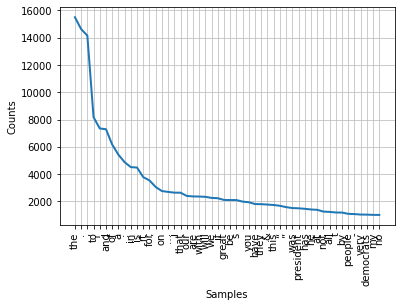

In [12]:
words = []
for tweet in data["text"]:
    words += tweet_tokenizer.tokenize(tweet)

fdist = nltk.FreqDist(words)
fdist.plot(50)

In [13]:
#高頻度のツイートを表示
df_fdist = pd.DataFrame(fdist.most_common(10), columns=['Word', 'Frequency'])
df_fdist

,Word,Frequency
0,the,15504
1,.,14634
2,",",14156
3,to,8172
4,!,7343
5,and,7289
6,of,6165
7,a,5419
8,:,4870
9,in,4507


In [0]:
#tokenにする
import re
import string

stemmer = nltk.stem.PorterStemmer()
punctuations = string.punctuation
all_tweets_clean = []

#Tweet毎にリスト形式で保存するための加工
result=[]

for tweet in data["text"]:
    # RTから始まる部分を取り除く。
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # リンクを取り除く。
    tweet = re.sub(r'(http|https):\/\/.*[\r\n]*', '', tweet)
    # ハッシュタグを取り除く。
    tweet = re.sub(r'#', '', tweet)
    # 句読点の削除
    tweet = tweet.translate(str.maketrans('', '', string.punctuation)) 
    # 単語に分解する。
    tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
    result.append(tweet_tokens)

In [0]:
stopwords = nltk.corpus.stopwords.words('english')
stop_words = ["→", "←", "?", "」", "「","(",")","!",".",",","&","…","%",":",";","“"]
stopwords += stop_words

#print(stopwords)

result_2=[]
result_3=[]
for i in range(len(result)):
    for word in result[i]:
        if word not in stopwords:
            result_2.append(word)
    result_3.append(result_2)
    result_2=[]

In [0]:
#Word2Vec

from gensim.models import word2vec

In [17]:
# 対象データをLinseSentence(one sentence = one lineとして扱う)で読み込む

sentences = result_3
sentences[0]

['steventdennis',
 'trump',
 'gets',
 'bump',
 'latest',
 'gallup',
 'poll',
 '49',
 'approval',
 '6',
 'tied',
 'best',
 '47',
 'disapproval',
 '7']

In [0]:
# skip-gramモデルの学習
skipgram_model = word2vec.Word2Vec(sentences,
                                   sg=1,
                                   size=300,
                                   min_count=10,
                                   window=15, seed=1234)

In [19]:
# 作成したモデルの保存
skipgram_model.save("skipgram_w2v.model")
# saveしたモデルを読み込む時は
#skipgram_model = word2vec.Word2Vec.load("skipgram_w2v.model")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [20]:
# coronavirusと似たキーワードを見つけていきます。
# ここで記載しているscoreは、単語同士のコサイン類似度です。
pd.DataFrame(skipgram_model.wv.most_similar(
    positive=["coronavirus"]), columns=["keyword", "score"])

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


,keyword,score
0,covid,0.849422
1,response,0.839187
2,spread,0.837546
3,task,0.833811
4,19,0.811066
5,outbreak,0.809031
6,executive,0.796829
7,briefing,0.795041
8,force,0.788158
9,cdcgov,0.780910


In [0]:
"""
1. 抽出された各単語を、作成したword2Vecによってベクトル化
2. 変換された各単語ベクトルの平均をとり、その結果得られたベクトルを記事のベクトルとする
上記2ステップを実行する関数を作成
"""

num_features = 300


def avg_document_vector(data, num_features):
    document_vec = np.zeros((len(data), num_features))
    for i, doc_word_list in enumerate(data):
        feature_vec = np.zeros((num_features,), dtype="float32")
        for word in doc_word_list:
            try:
                feature_vec = np.add(
                    feature_vec, skipgram_model.wv.__getitem__(word))
            except:
                pass

        feature_vec = np.divide(feature_vec, len(doc_word_list))
        document_vec[i] = feature_vec
    return document_vec

In [22]:
X = avg_document_vector(data=sentences, num_features=300)
X.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


(12259, 300)

In [23]:
# outer join
data2 = pd.DataFrame(X)
df_tweets_word2vec =  pd.concat([data, data2], axis=1)
df_tweets_word2vec.head()

,date,price,text,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,2020-05-01,2830.71,RT @StevenTDennis: Trump gets bump in latest G...,0.048241,0.059343,-0.074168,-0.102202,-0.027979,-0.006321,-0.003280,-0.025286,0.024393,0.009621,0.030607,-0.059204,0.010845,0.013499,0.027129,-0.010853,-0.091906,-0.073355,0.022842,0.033119,0.049701,0.057860,-0.026545,-0.063918,0.025201,-0.016992,0.039506,0.123442,-0.030186,-0.055474,-0.055225,-0.020549,0.029997,0.110299,0.056860,-0.047704,-0.089840,...,0.004570,-0.012826,-0.052159,-0.026116,-0.018429,-0.038315,-0.012312,0.025028,0.042201,0.009671,0.110060,-0.038436,-0.012172,0.017982,-0.010838,0.029899,0.033058,-0.065363,0.041728,0.022063,-0.054949,0.017375,0.001039,0.014454,-0.001970,-0.111772,0.063796,-0.139253,-0.041334,-0.046455,0.031132,0.011245,0.034879,0.007442,0.111581,0.001900,0.069504,-0.001583,0.054448,-0.006316
1,2020-05-01,2830.71,"The Governor of Michigan should give a little,...",0.067295,0.065737,-0.080651,-0.153470,-0.062781,0.084460,0.097882,-0.097466,0.025868,0.066413,0.026237,-0.060389,-0.041913,-0.002046,0.074839,-0.029249,-0.143069,-0.052183,0.057287,-0.043340,0.041600,0.110599,0.002549,-0.071241,-0.001593,-0.050672,0.138582,0.125802,0.021792,-0.175057,-0.022902,-0.145977,-0.006275,0.073208,-0.023674,-0.070486,0.018465,...,0.006060,-0.074807,-0.064379,-0.102687,-0.033679,-0.139021,0.018947,-0.006205,0.070146,-0.026273,0.106022,0.012643,0.043809,0.037522,-0.025560,0.068256,0.154969,-0.145763,0.117384,0.150921,-0.115617,0.071571,-0.017832,0.032463,0.085449,-0.150913,0.180492,-0.102506,-0.023194,-0.029429,0.021109,-0.027015,0.014771,-0.069248,0.201786,-0.037958,0.045962,-0.000133,0.042984,0.006437
2,2020-05-01,2830.71,"Cryin Chuck Schumer, compared to what other Se...",0.074129,0.054035,-0.047577,-0.138969,-0.024204,0.087372,0.048822,-0.110518,0.040400,0.053006,0.051875,-0.033936,-0.028880,0.044753,0.080675,-0.051941,-0.153464,-0.036111,0.080564,-0.006554,0.044138,0.057812,-0.004431,-0.062420,0.005022,-0.062594,0.096280,0.125239,0.023979,-0.173230,-0.016681,-0.141113,-0.001342,0.125666,-0.062361,-0.096085,0.019846,...,0.012987,-0.072538,-0.032089,-0.103827,-0.049592,-0.129789,0.028587,0.007459,0.011778,-0.021470,0.120637,-0.010403,0.010230,0.028169,0.010701,0.056492,0.111062,-0.124445,0.156269,0.125211,-0.105991,0.101536,-0.061251,0.026980,0.083413,-0.088980,0.094021,-0.105696,0.031988,-0.048122,0.015593,-0.007362,0.025080,-0.045592,0.197214,-0.055860,0.056453,-0.009692,0.015668,0.001125
3,2020-05-01,2830.71,Cryin’ Chuck Schumer was on a late night show ...,0.081467,0.091006,-0.059714,-0.152566,-0.025866,0.065605,0.064819,-0.119684,0.023666,0.052051,0.046519,-0.043284,-0.035385,-0.007623,0.085897,-0.062975,-0.142256,-0.039780,0.076933,0.005649,0.044619,0.056291,-0.019694,-0.106322,-0.008333,-0.070434,0.113172,0.143580,0.017615,-0.185084,-0.005173,-0.110970,0.033524,0.132542,-0.063583,-0.100868,-0.006367,...,0.035496,-0.092416,-0.035658,-0.068428,-0.075076,-0.137127,-0.018075,0.015359,0.025445,-0.020557,0.119552,0.001626,0.013843,0.003796,0.005564,0.068894,0.099190,-0.129789,0.124140,0.106475,-0.113288,0.082159,-0.009153,0.046931,0.100006,-0.103029,0.105299,-0.084166,0.032647,-0.044181,0.018581,-0.004457,0.008838,-0.044614,0.169575,-0.050989,0.090134,-0.003325,0.066744,0.017180
4,2020-05-01,2830.71,RT @TeamTrump: President @realDonaldTrump: “We...,0.055053,0.079258,-0.169880,-0.128334,-0.056022,0.045531,0.043898,-0.036433,-0.018799,0.050679,-0.015264,-0.028522,0.045297,-0.007759,0.067268,0.001515,-0.137767,-0.096647,0.074347,-0.026259,0.037565,0.121564,-0.028739,-0.102168,0.005849,0.007038,0.139539,0.201101,-0.012400,-0.086574,-0.052742,-0.064194,0.053290,0.132847,0.029767,-0.023630,-0.077173,...,0.042446,-0.035632,-0.039194,-0.086164,-0.018679,-0.045109,-0.0230

In [0]:
df_tweets_word2vec.to_csv("price_tweets_vector.csv", index=False)

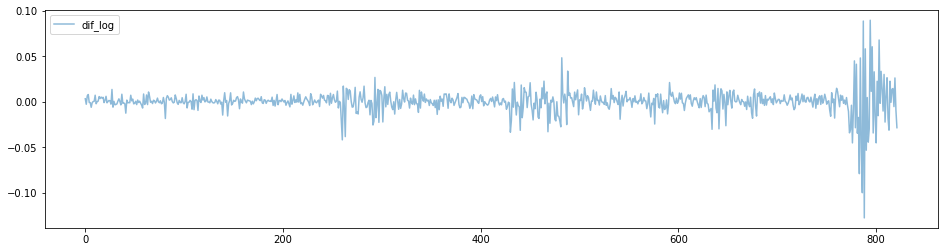

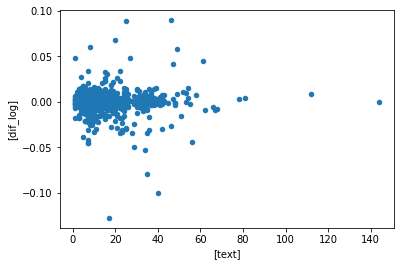

In [25]:
#ツイートのベクトルを1日毎に平均にする（1日10ツイートだった場合ベクトルと足し合わせ10で割る）
# groupby #https://qiita.com/propella/items/a9a32b878c77222630ae
df = df_tweets_word2vec.groupby(["date"]).mean()


# targetのcolである変化率（"price"の差分対数行列）をdateをKeyに内部結合する
df_sp = pd.read_csv("/content/sp500-10-year-daily-chart.csv")

# 時系列データの差分を求める

# " value"の行を対数化
# https://www.sejuku.net/blog/70027
df_sp["log"] = np.log(df_sp[" value"])

# "log"の1日前との差を取って、差分対数の列を作成
# https://note.nkmk.me/python-pandas-diff-pct-change/
df_sp["dif_log"] = df_sp["log"].diff()

#内部結合
df2=pd.merge(df_sp, df, how="inner" ,on="date")
df2 = df2.drop(" value", axis=1)

# groupbyを使って1日のツイート数も特徴量に加える
# https://deepage.net/features/pandas-count.html
df3 = df_tweets_word2vec[["date","text"]]
df3 = df3.groupby(["date"]).count()

#内部結合
df4 = pd.merge( df3, df2, how="inner" ,on="date")

#曜日を取得
df4['day_of_week'] = pd.to_datetime(df4['date']).dt.day_name()

#日付データの形を変える
df4["date"] = pd.to_datetime(df4['date']).astype('int64')

#変化率のグラフ
df4.plot( y=["dif_log"], figsize=(16,4), alpha=0.5)

#ツイート数と変化率の関係
df4.plot.scatter(x=["text"], y=["dif_log"])

In [0]:
dummy_df = pd.get_dummies(df4[['day_of_week']], drop_first = False) 
df4 = pd.merge(df4, dummy_df, left_index=True, right_index=True)

In [27]:
df4.head()

,date,text,log,dif_log,price,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,...,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,day_of_week,day_of_week_Friday,day_of_week_Monday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
0,1484870400000000000,13,7.728112,0.003361,2271.31,0.039028,0.048144,-0.116790,-0.113819,-0.051271,0.051119,0.083228,-0.074546,0.060662,0.034360,-0.006811,-0.088676,-0.043543,0.006891,0.043681,0.016932,-0.124626,-0.076917,0.028388,-0.022252,0.049078,0.162042,0.036462,-0.042952,0.025934,-0.030809,0.089874,0.115414,-0.021594,-0.108496,-0.021407,-0.107579,-0.052602,0.077441,0.043774,...,0.050593,-0.013868,0.110926,0.028264,0.138170,-0.009166,0.046440,0.051309,-0.027013,0.040693,0.177420,-0.101669,0.066925,0.119875,-0.082918,0.001342,0.013695,0.033186,0.000137,-0.192540,0.201087,-0.230852,-0.098995,-0.008057,0.042410,-0.039217,0.018669,-0.080276,0.168429,-0.039599,0.073293,-0.033928,0.045701,-0.036587,Friday,1,0,0,0,0
1,1485129600000000000,1,7.725418,-0.002694,2265.20,0.070658,0.109443,-0.127563,-0.121572,-0.043983,0.068067,0.076413,-0.090769,0.023657,0.056238,0.045125,-0.055560,-0.042072,-0.009179,0.043337,-0.016099,-0.141193,-0.045880,0.052846,-0.017003,0.034856,0.180826,0.019087,-0.068674,-0.003275,-0.016350,0.101193,0.115467,-0.011018,-0.099619,-0.064305,-0.033116,-0.021485,0.077383,0.023758,...,0.026861,-0.007287,0.132804,0.028646,0.120434,-0.044177,0.015531,0.062517,-0.022474,0.036432,0.140680,-0.139517,0.076756,0.112663,-0.072096,-0.007516,-0.005093,0.043058,0.008652,-0.238633,0.171336,-0.215003,-0.059756,-0.030833,0.004346,-0.037359,0.056583,-0.044331,0.148344,-0.019222,0.056231,0.006921,0.054767,-0.020726,Monday,0,1,0,0,0
2,1485216000000000000,4,7.731961,0.006543,2280.07,0.043864,0.077936,-0.092234,-0.095663,-0.035344,0.045021,0.096591,-0.091771,0.037087,0.054308,0.025081,-0.078451,-0.039211,-0.029181,0.038341,0.006028,-0.096779,-0.053858,0.033698,-0.013831,0.039417,0.166732,0.054202,-0.047496,-0.003072,-0.015217,0.084713,0.093606,-0.036187,-0.078603,-0.022574,-0.054516,-0.051124,0.026891,0.021063,...,-0.004900,-0.018151,0.122476,0.043280,0.095348,-0.017912,0.028934,0.045192,-0.039490,0.026784,0.116895,-0.104189,0.063241,0.114574,-0.045093,-0.035226,0.020432,0.041795,-0.003602,-0.202587,0.168288,-0.186976,-0.066002,-0.010689,0.000351,-0.060908,0.023224,-0.089798,0.082105,-0.028434,0.077065,0.003066,0.058131,-0.003658,Tuesday,0,0,0,1,0
3,1485302400000000000,8,7.739955,0.007994,2298.37,0.057195,0.073653,-0.070744,-0.113591,-0.028205,0.040374,0.039095,-0.110164,0.049338,0.020370,0.034911,-0.069594,-0.050953,-0.009835,0.065969,-0.022926,-0.105823,-0.050099,0.062980,0.007597,0.061724,0.098381,0.021523,-0.064969,-0.013956,-0.044256,0.050207,0.092324,-0.007561,-0.119464,-0.024535,-0.052591,-0.036366,0.091938,-0.016241,...,-0.004749,-0.008330,0.071204,0.030370,0.106743,-0.005506,0.018290,-0.001510,-0.018842,0.016694,0.102249,-0.111348,0.102811,0.072968,-0.079947,0.027687,0.028829,0.057653,0.022626,-0.152398,0.102874,-0.187636,-0.009599,-0.025949,0.023957,-0.032492,0.023595,-0.059010,0.120890,-0.019593,0.081388,0.010520,0.045260,0.003871,Wednesday,0,0,0,0,1
4,1485388800000000000,11,7.739220,-0.000736,2296.68,0.051580,0.069645,-0.069430,-0.104721,-0.028555,0.049190,0.051731,-0.070246,0.028808,0.026537,0.007293,-0.077292,-0.024199,-0.016881,0.044888,-0.005435,-0.112708,-0.068343,0.065873,-0.005304,0.035526,0.125818,0.028857,-0.073613,-0.001915,-0.032942,0.075969,0.103884,-0.023790,-0.091854,-0.023097,-0.046076,-0.012948,0.089587,0.000889,...,-0.008856,-0.005541,0.098732,0.055383,0.126338,0.002022,0.029109,0.036573,-0.021490,0.036975,0.106038,-0.105972,0.082855,0.078429,-0.069631,0.019982,0.022515,0.065746,0.025177,-0.179145,0.136295,-0.184884,-0.040728,0.003143,0.040934,-0.043925,0.041071,-0.053095,0.129720,-0.013559,0.087412,0.001625,0.045862,-0.002382,Thursday,

In [0]:
#特徴量とターゲットを決める
from sklearn.model_selection import train_test_split

target_col = 'dif_log'
exclude_cols = ['log', 'price', 'dif_log', "date","text","day_of_week"]
feature_cols = []
for col in df4.columns:
    if col not in exclude_cols:
        feature_cols.append(col)
        
X = np.array(df4[feature_cols])
y = np.array(df4[target_col])

In [29]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, random_state=1234)

print('X_train_val Features Shape: ', X_train_val.shape)
print('y_train_val Target Shape: ', y_train_val.shape)
print('X_test Features Shape: ', X_test.shape)
print('y_test Target Shape: ', y_test.shape)

X_train_val Features Shape:  (739, 305)
y_train_val Target Shape:  (739,)
X_test Features Shape:  (83, 305)
y_test Target Shape:  (83,)


In [30]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.1, random_state=1234)

# 参考：分割後のデータ数を確認
print('X_train Features Shape: ', X_train.shape)
print('y_train Target Shape: ', y_train.shape)
print('X_val Features Shape: ', X_val.shape)
print('y_val Target Shape: ', y_val.shape)

X_train Features Shape:  (665, 305)
y_train Target Shape:  (665,)
X_val Features Shape:  (74, 305)
y_val Target Shape:  (74,)


In [0]:
#分析用のライブラリ

from collections import Counter
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LinearRegression  # 線形回帰モデルのライブラリ
from sklearn.metrics import mean_squared_error  # MSEのライブラリ
from sklearn.ensemble import RandomForestRegressor

In [32]:
#分析1 線形回帰

from sklearn.linear_model import LinearRegression  # 線形回帰モデルのライブラリ
from sklearn.metrics import mean_squared_error  # MSEのライブラリ
from sklearn.externals import joblib
import pickle

lm = LinearRegression()
lm.fit(X_train, y_train)

# モデルを保存する
filename = 'lm_model.sav'
pickle.dump(lm, open(filename, 'wb'))

y_pred = lm.predict(X_val)
lm_mse = mean_squared_error(y_val, y_pred)
print('LinerRegression RMSE: ', round(np.sqrt(lm_mse), 3))

LinerRegression RMSE:  0.021


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [33]:
#保存したモデルを読み取る
loaded_model = pickle.load(open(filename, 'rb'))

y_pred = loaded_model.predict(X_val)
lm_mse = mean_squared_error(y_val, y_pred)
print('LinerRegression RMSE: ', round(np.sqrt(lm_mse), 3))

LinerRegression RMSE:  0.021


In [34]:
#分析2 決定木

from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=1234)
dt.fit(X_train, y_train)

# モデルを保存する
filename = 'dt_model.sav'
pickle.dump(dt, open(filename, 'wb'))

y_pred = dt.predict(X_val)
dt_mse = mean_squared_error(y_val, y_pred)
print('DecisionTreeRegressor RMSE: ', round(np.sqrt(dt_mse), 3))

DecisionTreeRegressor RMSE:  0.017


In [35]:
#分析3 ランダムフォレスト

from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=1234)
rf.fit(X_train, y_train)

# モデルを保存する
filename = 'rf_model.sav'
pickle.dump(rf, open(filename, 'wb'))

y_pred = rf.predict(X_val)
rf_mse = mean_squared_error(y_val, y_pred)
print('RandomForestRegressor RMSE: ', round(np.sqrt(rf_mse), 3))

RandomForestRegressor RMSE:  0.013


In [36]:
#分析2.5 Lasso回帰：説明変数が多い場合に精度が上がるモデル

from sklearn.linear_model import Lasso
ls = Lasso(alpha=0.01, random_state=1234)
ls.fit(X_train, y_train)

# モデルを保存する
filename = 'ls_model.sav'
pickle.dump(ls, open(filename, 'wb'))

y_pred = ls.predict(X_val)
ls_mse = mean_squared_error(y_val, y_pred)
print('LassoRegressor RMSE: ', round(np.sqrt(ls_mse), 3))

LassoRegressor RMSE:  0.013


In [37]:
#分析2.5 Ridge回帰

from sklearn.linear_model import Ridge
rd = Ridge(alpha=0.01, random_state=1234)

rd.fit(X_train, y_train)

# モデルを保存する
filename = 'rd_model.sav'
pickle.dump(ls, open(filename, 'wb'))

y_pred = rd.predict(X_val)
rd_mse = mean_squared_error(y_val, y_pred)
print('RidgeRegressor RMSE: ', round(np.sqrt(rd_mse), 3))


RidgeRegressor RMSE:  0.013


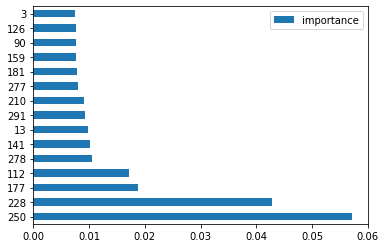

In [38]:
#分析3 ランダムフォレストの特徴量

rf_importances = pd.DataFrame(rf.feature_importances_, columns=['importance'], index=feature_cols)
rf_importances.sort_values('importance', ascending=False).iloc[0:15].plot(kind='barh')

In [39]:
#3つの分析の結果の比較

print('線形回帰モデルのRMSE:    ', round(np.sqrt(lm_mse), 3))
print('回帰木のRMSE:                  ', round(np.sqrt(dt_mse), 3))
print('ランダムフォレストのRMSE: ', round(np.sqrt(rf_mse), 3))
print('Lasso回帰のRMSE: ', round(np.sqrt(ls_mse), 3))

線形回帰モデルのRMSE:     0.021
回帰木のRMSE:                   0.017
ランダムフォレストのRMSE:  0.013
Lasso回帰のRMSE:  0.013


In [40]:
#分析4 ランダムフォレストのチューニング

# クロスバリデーションとグリッドサーチ のライブラリ
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor(random_state=1234)

params = {'n_estimators': [10, 25, 50, 100], 'max_depth': [10, 20, 30, 50]}
gscv = GridSearchCV(rf, param_grid=params, verbose=1, cv=3,
                    scoring='neg_mean_squared_error', n_jobs=-1)
gscv.fit(X_train, y_train)

gscv.best_params_

Fitting 3 folds for each of 16 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  2.2min finished


{'max_depth': 20, 'n_estimators': 50}

In [42]:
#分析4 ランダムフォレストのチューニング
best_estimators = gscv.best_params_["n_estimators"]
best_depth = gscv.best_params_["max_depth"]

rf_best = RandomForestRegressor(n_estimators=best_estimators, max_depth=best_depth, random_state=1234)
rf_best.fit(X_train, y_train)

# モデルを保存する
filename = 'rf_best_model.sav'
pickle.dump(rf_best, open(filename, 'wb'))

y_pred = rf_best.predict(X_val)
rf_best_mse = mean_squared_error(y_val, y_pred)
print('RandomForest RMSE: ', round(np.sqrt(rf_best_mse), 3))

RandomForest RMSE:  0.013


In [43]:
#分析5 チューニングしたモデルにテストデータを代入

y_pred_on_test = rf_best.predict(X_test)
rf_best_test_mse = mean_squared_error(y_test, y_pred_on_test)
print('RandomForest RMSE: ', round(np.sqrt(rf_best_test_mse), 3))

RandomForest RMSE:  0.011


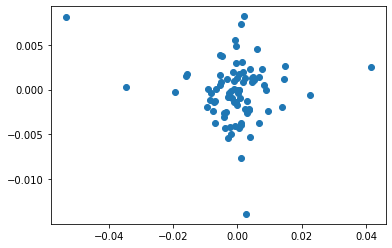

Mean:  1.30229
Std:  2.91154


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


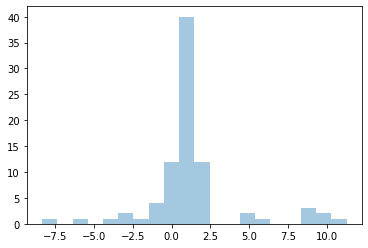

In [44]:
#分析5 テストデータを代入
#誤差を可視化

plt.scatter(y_test, y_pred_on_test)
plt.show()

import seaborn as sns

error_rate = (y_test - y_pred_on_test) / y_test
print('Mean: ', round(np.mean(error_rate), 5))
print('Std: ', round(np.std(error_rate), 5))
sns.distplot(error_rate, kde=False, rug=False, bins=20)

In [45]:
#分析6 クラスタリング
#https://hironsan.hatenablog.com/entry/clustering-word-vectors

from collections import defaultdict
from gensim.models.keyedvectors import KeyedVectors
from sklearn.cluster import KMeans

model = KeyedVectors.load('skipgram_w2v.model')
max_vocab = 30000
vocab = list(model.wv.vocab.keys())[:max_vocab]
vectors = [model.wv[word] for word in vocab]

n_clusters = 30
kmeans_model = KMeans(n_clusters=n_clusters, verbose=1, random_state=1234, n_jobs=-1)
kmeans_model.fit(vectors)

cluster_labels = kmeans_model.labels_
cluster_to_words = defaultdict(list)
for cluster_id, word in zip(cluster_labels, vocab):
    cluster_to_words[cluster_id].append(word)

for words in cluster_to_words.values():
    print(words[:10])

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


['trump', 'teamtrump', 'realdonaldtrump', '\u2066', '\u2069', 'potus', 'interview', 'marthamaccallum', 'joe', 'dbongino']
['gets', 'totally', 'loser', 'thing', 'never', 'even', 'called', 'wonder', 'show', 'talking']
['latest', 'fire', 'president', 'pandemic', 'hughhewitt', 'direction', 'strategy', 'may', 'line', 'significant']
['poll', '6', 'best', '7', 'one', 'point', '8', 'days', 'history', 'gopchairwoman']
['approval', 'republican', 'party', 'rating', 'overall', '95', '53', 'seats']
['tied', 'using', '”', 'gave', 'cop', 'seems', 'bucksexton', 'responsible', 'general', 'tried']
['governor', 'job', 'opponent', 'tom', 'jersey', 'kevin', 'state', 'brian', 'ryan', 'conservative']
['michigan', 'night', 'great', '2020', 'incredible', 'wisconsin', 'proud', 'iowa', 'thank', 'supporting']
['give', 'want', 'cryin', 'chuck', 'schumer', '’', 'aoc', 'enough', 'run', 'something']
['little', 'put', 'given', 'others', 'would', 'else', 'spent', 'payments', 'already', 'come']
['good', 'people', 'back'

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


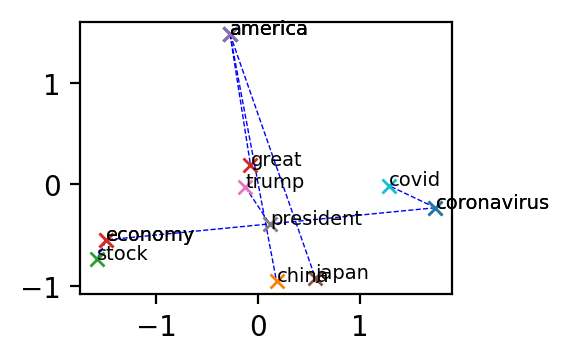

In [46]:
#分析7 似ている単語をプロット
# https://yoshipc.net/python-word2vec/
 
from gensim.models import word2vec
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
 
model = word2vec.Word2Vec.load("/content/skipgram_w2v.model")
 
#調べる情報を配列に収納
trump_word = []
trump_word.append(["america","china"])
trump_word.append(["america","great"])
trump_word.append(["america","japan"])
trump_word.append(["trump","president"])
trump_word.append(["coronavirus","covid"])
trump_word.append(["coronavirus","economy"])
trump_word.append(["stock","economy"])

length = len(trump_word)
data = []
 
j = 0
while j < length:
    #print(trump_word[j][1])
    data.append(model[trump_word[j][0]])
    data.append(model[trump_word[j][1]])
    j += 1
 
pca = PCA(n_components=2)
pca.fit(data)
data_pca= pca.transform(data)
 
length_data = len(data_pca)
 
i = 0
j = 0

plt.figure(figsize=(2.4, 1.8), dpi=200)

while i < length_data:
    #点プロット
    plt.plot(data_pca[i][0], data_pca[i][1], ms=5.0, zorder=2 ,marker="x")
    plt.plot(data_pca[i+1][0], data_pca[i+1][1],ms=5.0, zorder=2 ,marker="x")
 
    #線プロット
    plt.plot((data_pca[i][0], data_pca[i+1][0]),(data_pca[i][1],data_pca[i+1][1]),c="b",linewidth=0.5,zorder=1,linestyle="--")
 
    #文字プロット
    plt.annotate(trump_word[j][0],(data_pca[i][0], data_pca[i][1]),size=7)
    plt.annotate(trump_word[j][1],(data_pca[i+1][0], data_pca[i+1][1]),size=7)
 
    j += 1
    i += 2
 
plt.show()

In [0]:
#分析8 DeepLearning
#ライブラリをインポート

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [0]:
class myMLP(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.ln1 = nn.Linear(in_features, 64)
        self.ln2 = nn.Linear(64, 16)
        self.ln3 = nn.Linear(16, 4)
        self.ln4 = nn.Linear(4, out_features)

    def forward(self, x):
        x = self.ln1(x)
        x = F.relu(x)
        x = self.ln2(x)
        x = F.relu(x)
        x = self.ln3(x)
        x = F.relu(x)
        x = self.ln4(x)
        
        return x

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([57])) that is different to the input size (torch.Size([57, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([165])) that is different to the input size (torch.Size([165, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input

test_loss:  tensor(0.0001, grad_fn=<DivBackward0>)


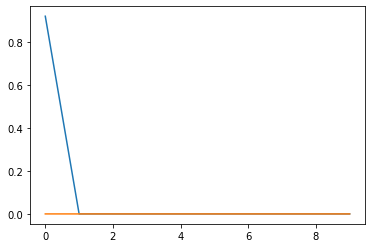

In [49]:
#分析8 DeepLearning
# NumPyのarryをtorch.tensor型に変換する。

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1234)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

#ネットワークを書く
net = myMLP(305,1)
net.parameters

#目的関数を指定（今回は回帰問題のためMSELoss()を使用する）
#https://pytorch.org/docs/stable/nn.html#loss-functions
loss_func = nn.MSELoss()
#Optimizerを定義する
#https://pytorch.org/docs/stable/optim.html
optimizer = optim.RMSprop(net.parameters())
  
train_loss_track = []
test_loss_track = []

for epoc in range(10):
    running_loss = 0
    
    # 学習モード
    net.train()
    for step, (xx, yy)  in enumerate(train_loader):
        
        # 最後に計算した各パラメーターの勾配を初期化する
        optimizer.zero_grad()
        
        # フォワード計算を行う
        y_pred = net(xx).float()
        
        # 誤差関数を使ってギャップの計測
        loss = loss_func(y_pred, yy)
      
        # 誤差逆伝播法を使って自動微分
        loss.backward()
        
        # パラメーターを更新
        optimizer.step()
        
        # 学習データを使って誤差を計算
        running_loss += loss.item()
        
    # エポックが終了したら平均誤差を計算
    train_loss_track.append(running_loss/step)
    
    
    #評価（evaluation）モード
    net.eval()
    
    # 予測値を計算
    y_pred = net(X_test_tensor)
    
    # 誤差関数を計算
    test_loss = loss_func(y_pred, y_test_tensor)
    
    # 誤差をトラッキング
    test_loss_track.append(test_loss)



plt.plot(train_loss_track)
plt.plot(test_loss_track)
print("test_loss: ",sum(test_loss_track)/len(test_loss_track))

RandomForestRegressor RMSE:  0.016
['confident']
['coronavirus']
['declare']
['nationwide']
['duly']
['spreading']
['covid19']
['cutter']
['545']
['outbreak']
['practice']
['prevail']
['billcassidy']
['restaurants']
['powerfully']


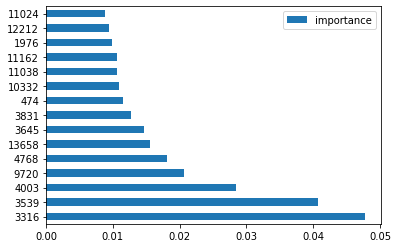

In [51]:
#分析9　TFIDFを用いたランダムフォレスト

#形態素解析のデータセットを作る
#https://qiita.com/tomone_hata/items/67e7f9415dbf5c8ff8ba

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#形態素解析のデータセットを作る
#文章を全部１つのリストに入れる→TFIDFを作る→それぞれの日付に出てくる単語をKeyにTFIDFの値を取ってくる

data_keitaiso = pd.read_csv("s&p_tweets.csv")
tweet_keitaiso=[]

for tweet in data_keitaiso["text"]:
  tweet = re.sub(r'^RT[\s]+', '', tweet)
  tweet = re.sub(r'(http|https):\/\/.*[\r\n]*', '', tweet)
  tweet = re.sub(r'#', '', tweet)
  tweet = tweet.translate(str.maketrans('', '', string.punctuation)) 
  tweet_keitaiso.append(tweet)

corpus = tweet_keitaiso         
cv = CountVectorizer(token_pattern=r"\b\w+\b")
wc = cv.fit_transform(corpus)
ttf = TfidfTransformer()
tfidf = ttf.fit_transform(wc)

#蜜行列に変更する
X_tfidf = tfidf.toarray()

data3 = pd.DataFrame(X_tfidf)
df_tweets_tfidf =  pd.concat([data_keitaiso, data3], axis=1)

df = df_tweets_tfidf.groupby(["date"]).mean()
df_sp = pd.read_csv("/content/sp500-10-year-daily-chart.csv")
df_sp["log"] = np.log(df_sp[" value"])
df_sp["dif_log"] = df_sp["log"].diff()
df2=pd.merge(df_sp, df, how="inner" ,on="date")
df2 = df2.drop(" value", axis=1)
df3 = df_tweets_tfidf[["date","text"]]
df3 = df3.groupby(["date"]).count()
df_tfidf = pd.merge( df3, df2, how="inner" ,on="date")
df_tfidf['day_of_week'] = pd.to_datetime(df_tfidf['date']).dt.day_name()
df_tfidf["date"] = pd.to_datetime(df4['date']).astype('int64')

dummy_df = pd.get_dummies(df_tfidf[['day_of_week']], drop_first = False) 
df_tfidf = pd.merge(df_tfidf, dummy_df, left_index=True, right_index=True)

from sklearn.model_selection import train_test_split

target_col = 'dif_log'
exclude_cols = ['log', 'price', 'dif_log', "date","text","day_of_week"]
feature_cols = []
for col in df_tfidf.columns:
    if col not in exclude_cols:
        feature_cols.append(col)
        
X2 = np.array(df_tfidf[feature_cols])
y2 = np.array(df_tfidf[target_col])

X２_train_val, X２_test, y２_train_val, y２_test = train_test_split(
    X２, y２, test_size=0.1, random_state=1234)

X２_train, X２_val, y２_train, y２_val = train_test_split(
    X２_train_val, y２_train_val, test_size=0.1, random_state=1234)

#分析
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=100, random_state=1234)
rf.fit(X２_train, y２_train)

filename = 'rf_TFIDF_model.sav'
pickle.dump(rf, open(filename, 'wb'))

y２_pred = rf.predict(X２_val)
rf_mse_2 = mean_squared_error(y２_val, y２_pred)
print('RandomForestRegressor RMSE: ', round(np.sqrt(rf_mse_2), 3))

#プロット
rf_importances = pd.DataFrame(rf.feature_importances_, columns=['importance'], index=feature_cols)
rf_importances.sort_values('importance', ascending=False).iloc[0:15].plot(kind='barh')

#列名をゲット
#https://note.nkmk.me/python-dict-get-key-from-value/

voca = cv.vocabulary_

def get_keys_from_value(d, val):
    return [k for k, v in d.items() if v == val]

for i in rf_importances.sort_values('importance', ascending=False).iloc[0:15].index:
  keys = get_keys_from_value(voca, i)
  print(keys)
# ['key1', 'key2']

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([57])) that is different to the input size (torch.Size([57, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:432: UserWarning: Using a target size (torch.Size([165])) that is different to the input size (torch.Size([165, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input

test_loss:  tensor(0.0010, grad_fn=<DivBackward0>)


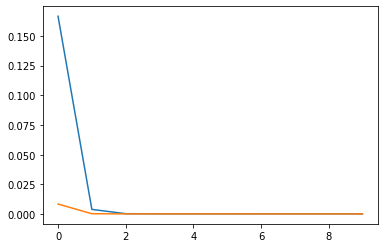

In [52]:
#分析10　形態素解析でDeepLearning

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X２, y2, test_size=0.2, random_state=1234)

X2_train_tensor = torch.tensor(X2_train, dtype=torch.float32)
y2_train_tensor = torch.tensor(y2_train, dtype=torch.float32)
X2_test_tensor = torch.tensor(X2_test, dtype=torch.float32)
y2_test_tensor = torch.tensor(y2_test, dtype=torch.float32)

train2_dataset = TensorDataset(X2_train_tensor, y2_train_tensor)
train2_loader = DataLoader(train2_dataset, batch_size=100, shuffle=True)

#ネットワークを書く
net = myMLP(16498,1)
net.parameters

#目的関数を指定（今回は回帰問題のためMSELoss()を使用する）
#https://pytorch.org/docs/stable/nn.html#loss-functions
loss_func = nn.MSELoss()
#Optimizerを定義する
#https://pytorch.org/docs/stable/optim.html
optimizer = optim.RMSprop(net.parameters())
  
train_loss_track = []
test_loss_track = []

for epoc in range(10):
    running_loss = 0
    
    # 学習モード
    net.train()
    for step, (xx, yy)  in enumerate(train2_loader):
        
        # 最後に計算した各パラメーターの勾配を初期化する
        optimizer.zero_grad()
        
        # フォワード計算を行う
        y_pred = net(xx).float()
        
        # 誤差関数を使ってギャップの計測
        loss = loss_func(y_pred, yy)
      
        # 誤差逆伝播法を使って自動微分
        loss.backward()
        
        # パラメーターを更新
        optimizer.step()
        
        # 学習データを使って誤差を計算
        running_loss += loss.item()
        
    # エポックが終了したら平均誤差を計算
    train_loss_track.append(running_loss/step)
    
    
    #評価（evaluation）モード
    net.eval()
    
    # 予測値を計算
    y_pred = net(X2_test_tensor)
    
    # 誤差関数を計算
    test_loss = loss_func(y_pred, y2_test_tensor)
    
    # 誤差をトラッキング
    test_loss_track.append(test_loss)



plt.plot(train_loss_track)
plt.plot(test_loss_track)
print("test_loss: ",sum(test_loss_track)/len(test_loss_track))

In [53]:
#分析11 アンサンブル学習
# https://blog.ikedaosushi.com/entry/2018/10/21/204842?t=0

random_state = 1234

X_train_valid, X_meta_valid, y_train_valid, y_meta_valid = train_test_split(X, y, test_size=0.1, random_state=random_state)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, test_size=0.1, random_state=random_state)

import lightgbm as lgb
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from lightgbm import LGBMRegressor

# train base model
base_model_1 = LinearRegression()
base_model_2 = LGBMRegressor()
base_model_3 = KNeighborsRegressor()

base_model_1.fit(X_train, y_train)
base_model_2.fit(X_train, y_train)
base_model_3.fit(X_train, y_train)

# base predicts
base_pred_1 = base_model_1.predict(X_valid)
base_pred_2 = base_model_2.predict(X_valid)
base_pred_3 = base_model_3.predict(X_valid)

# test predicts for final result 
valid_pred_1 = base_model_1.predict(X_meta_valid)
valid_pred_2 = base_model_2.predict(X_meta_valid)
valid_pred_3 = base_model_3.predict(X_meta_valid)

print ("mean squared error of model 1: {:.4f}".format(mean_squared_error(y_meta_valid, valid_pred_1)) )
print ("mean squared error of model 2: {:.4f}".format(mean_squared_error(y_meta_valid, valid_pred_2)) )
print ("mean squared error of model 3: {:.4f}".format(mean_squared_error(y_meta_valid, valid_pred_3)) )

# stack base predicts for training meta model
stacked_predictions = np.column_stack((base_pred_1, base_pred_2, base_pred_3))

# stack test predicts for final result 
stacked_valid_predictions = np.column_stack((valid_pred_1, valid_pred_2, valid_pred_3))

# train meta model 
meta_model = LinearRegression()
meta_model.fit(stacked_predictions, y_valid)

filename = 'meta_model.sav'
pickle.dump(meta_model, open(filename, 'wb'))

# final result 
meta_valid_pred = meta_model.predict(stacked_valid_predictions)
print ("mean squared error of meta model: {:.4f}".format(mean_squared_error(y_meta_valid, meta_valid_pred)) )


mean squared error of model 1: 0.0003
mean squared error of model 2: 0.0001
mean squared error of model 3: 0.0002
mean squared error of meta model: 0.0001


In [54]:
f = open('/content/trump_test.txt', 'r')
text = f.read()
mylist = literal_eval(text)

df_text=[]
df_created_at=[]
df_id_str=[]

for i in range(len(mylist)):
    text = mylist[i]["text"]
    created_at = mylist[i]["created_at"]
    id_str = mylist[i]["id_str"]
    df_text.append(text)
    df_created_at.append(created_at)
    df_id_str.append(id_str)

tweet_list=[df_created_at,df_id_str,df_text]

columns1=["created_at"]
tweet_data = pd.DataFrame( data = df_created_at, columns = columns1)
tweet_data["id"]=df_id_str
tweet_data["text"] = df_text

tweet_data["time_created_at"] = pd.to_datetime(tweet_data['created_at'])
tweet_data["date_created_at"] = tweet_data["time_created_at"].dt.date
tweet_data["key"]=pd.to_datetime(tweet_data["date_created_at"])

sp_data = pd.read_csv('/content/sp500-10-year-daily-chart.csv')
sp_data["date_64"] = pd.to_datetime(sp_data["date"])
sp_data["key"] =sp_data["date_64"] 

tweet_data=pd.merge(tweet_data, sp_data)
tweet_data.columns
data = tweet_data[["key"," value","text"]]

#行の名前を変更する　20200505
data = data.rename(columns={"key": "date"," value":"price"})
data.head()

import datetime as dt
data2 = data[(data['date'] >= dt.datetime(2019,5,1)) & (data['date'] <= dt.datetime(2022,5,31))]
print( "2020/05/02 - 2020/05/31のツイート数は", len(data2))
data2.to_csv("s&p_tweets_test.csv", index=False, mode='a', header=True)

data = pd.read_csv("s&p_tweets_test.csv")
print( len(data),"tweets")

import re
import string

stemmer = nltk.stem.PorterStemmer()
punctuations = string.punctuation
all_tweets_clean = []

#Tweet毎にリスト形式で保存するための加工
result=[]

for tweet in data["text"]:
    # RTから始まる部分を取り除く。
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # リンクを取り除く。
    tweet = re.sub(r'(http|https):\/\/.*[\r\n]*', '', tweet)
    # ハッシュタグを取り除く。
    tweet = re.sub(r'#', '', tweet)
    # 句読点の削除
    tweet = tweet.translate(str.maketrans('', '', string.punctuation)) 
    # 単語に分解する。
    tokenizer = nltk.tokenize.TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)
    result.append(tweet_tokens)
    
stopwords = nltk.corpus.stopwords.words('english')
stop_words = ["→", "←", "?", "」", "「","(",")","!",".",",","&","…","%",":",";","“"]
stopwords += stop_words

#print(stopwords)

result_2=[]
result_3=[]
for i in range(len(result)):
    for word in result[i]:
        if word not in stopwords:
            result_2.append(word)
    result_3.append(result_2)
    result_2=[]

from gensim.models import word2vec
skipgram_model = word2vec.Word2Vec.load("/content/skipgram_w2v.model")

num_features = 300


def avg_document_vector(data, num_features):
    document_vec = np.zeros((len(data), num_features))
    for i, doc_word_list in enumerate(data):
        feature_vec = np.zeros((num_features,), dtype="float32")
        for word in doc_word_list:
            try:
                feature_vec = np.add(
                    feature_vec, skipgram_model.wv.__getitem__(word))
            except:
                pass

        feature_vec = np.divide(feature_vec, len(doc_word_list))
        document_vec[i] = feature_vec
    return document_vec

sentences = result_3
sentences[0]

X = avg_document_vector(data=sentences, num_features=300)
X.shape


data2 = pd.DataFrame(X)
df_tweets_word2vec =  pd.concat([data, data2], axis=1)

df_tweets_word2vec.to_csv("price_tweets_vector.csv", index=False)

#ツイートのベクトルを1日毎に平均にする（1日10ツイートだった場合ベクトルと足し合わせ10で割る）
# groupby #https://qiita.com/propella/items/a9a32b878c77222630ae
df = df_tweets_word2vec.groupby(["date"]).mean()


# targetのcolである変化率（"price"の差分対数行列）をdateをKeyに内部結合する
df_sp = pd.read_csv("/content/sp500-10-year-daily-chart.csv")

# 時系列データの差分を求める

# " value"の行を対数化
# https://www.sejuku.net/blog/70027
df_sp["log"] = np.log(df_sp[" value"])

# "log"の1日前との差を取って、差分対数の列を作成
# https://note.nkmk.me/python-pandas-diff-pct-change/
df_sp["dif_log"] = df_sp["log"].diff()

#内部結合
df2=pd.merge(df_sp, df, how="inner" ,on="date")
df2 = df2.drop(" value", axis=1)

# groupbyを使って1日のツイート数も特徴量に加える
# https://deepage.net/features/pandas-count.html
df3 = df_tweets_word2vec[["date","text"]]
df3 = df3.groupby(["date"]).count()

#内部結合
df4 = pd.merge( df3, df2, how="inner" ,on="date")

#曜日を取得
df4['day_of_week'] = pd.to_datetime(df4['date']).dt.day_name()

date_for_result = df4["date"]

#日付データの形を変える
df4["date"] = pd.to_datetime(df4['date']).astype('int64')


dummy_df = pd.get_dummies(df4[['day_of_week']], drop_first = False) 
df4 = pd.merge(df4, dummy_df, left_index=True, right_index=True)

2020/05/02 - 2020/05/31のツイート数は 620
620 tweets


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide


Linear Regression　: RMSE 0.021
Decision Tree　: RMSE 0.015
Random Forest　: RMSE 0.014
Random Forest Best　: RMSE 0.016
Lasso　: RMSE 0.014
Ridge　: RMSE 0.014


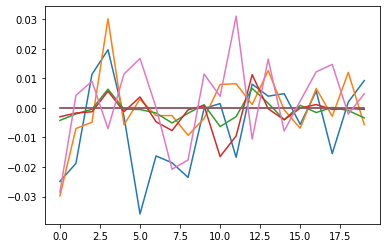

In [55]:
#特徴量とターゲットを決める
from sklearn.model_selection import train_test_split

target_col = 'dif_log'
exclude_cols = ['log', 'price', 'dif_log', "date","text","day_of_week"]
feature_cols = []
for col in df4.columns:
    if col not in exclude_cols:
        feature_cols.append(col)
        
X = np.array(df4[feature_cols])
y = np.array(df4[target_col])

from sklearn.externals import joblib
import pickle

files = [("Linear Regression",'/content/lm_model.sav'),("Decision Tree",'/content/dt_model.sav'),("Random Forest",'/content/rf_model.sav'),("Random Forest Best",'/content/rf_best_model.sav'),("Lasso","/content/ls_model.sav"),("Ridge","/content/rd_model.sav")]
df_result = pd.DataFrame(df4["dif_log"])

for i,(name,filename) in enumerate(files):
  loaded_model = pickle.load(open(filename, 'rb'))
  y_pred = loaded_model.predict(X)
  mse = mean_squared_error(y, y_pred)
  df_result[name] = y_pred
  print(name+"　: RMSE", round(np.sqrt(mse), 3))
  plt.plot(df_result[name])
plt.plot(df_result["dif_log"])

plt.show()

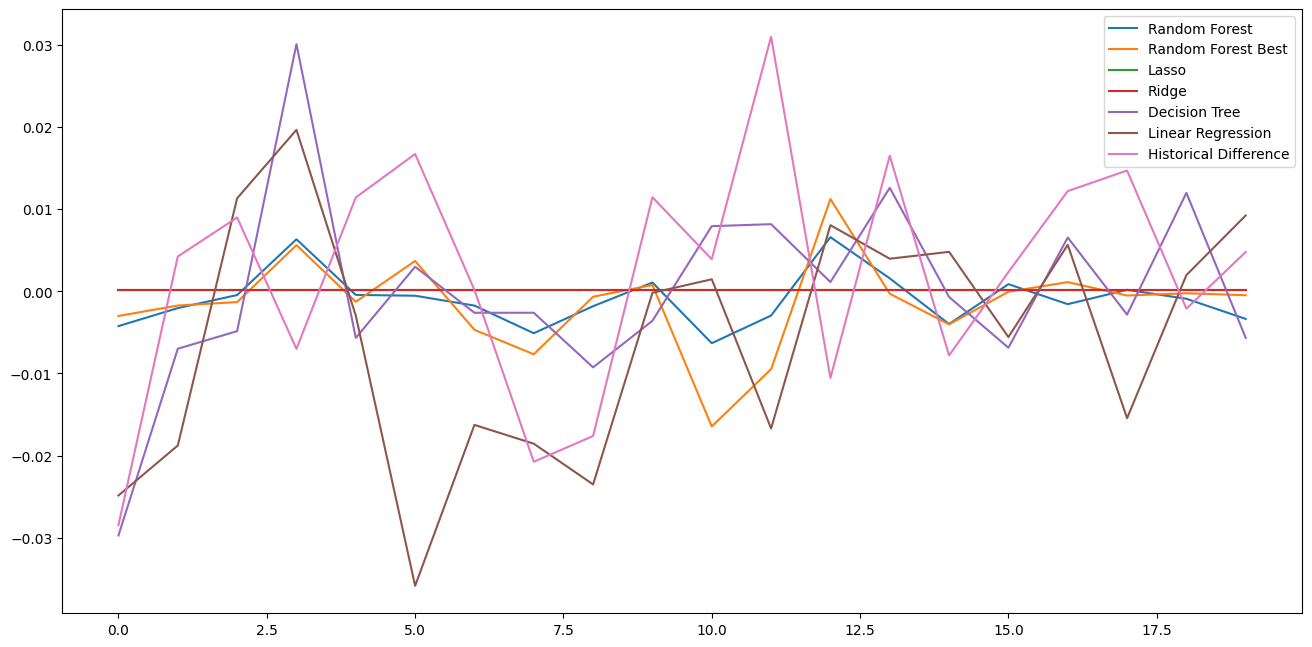

In [64]:
fig = plt.figure(figsize=(16,8),dpi=100)
rf = plt.plot(df_result["Random Forest"])
rf_b =plt.plot(df_result["Random Forest Best"])
ls =plt.plot(df_result["Lasso"])
rd =plt.plot(df_result["Ridge"])
dt = plt.plot(df_result["Decision Tree"])
ln = plt.plot(df_result["Linear Regression"])
sp = plt.plot(df_result["dif_log"])
plt.legend((rf[0], rf_b[0], ls[0], rd[0], dt[0], ln[0], sp[0]), ("Random Forest", "Random Forest Best", "Lasso", "Ridge", "Decision Tree","Linear Regression", "Historical Difference"), loc=0)

In [0]:
#上手くいってない
#分析6 Doc2Vecでツイートをクラスタリングする①
#https://qiita.com/g-k/items/5ea94c13281f675302ca

#from gensim.models.doc2vec import Doc2Vec, TaggedDocument
#from gensim import models

#documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(sentences)]
#model = Doc2Vec(documents, vector_size=300, window=5, min_count=1, workers=4)
#model.save("doc2_w2v.model")

In [0]:
#上手くいってない
#分析6 Doc2Vecでツイートをクラスタリングする②
#https://qiita.com/naotaka1128/items/e617f63907fed035408a

#model = models.Doc2Vec.load('/content/doc2_w2v.model')

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def draw_word_scatter(word, topn=30):
    """ 入力されたwordに似ている単語の分布図を描くためのメソッド """

    # 似ている単語を求めるためにはGensim word2vecの以下の機能を利用
    # model.most_similar(word, topn=topn)
    words = [x[0] for x in sorted(model.most_similar(word, topn=topn))]
    words.append(word)

    # 各単語のベクトル表現を求めます。Gensimのmost_similarをベースとして
    # 単語のベクトルを返すメソッド(model.calc_vec)を定義しています
    # 長くなるので実装は本稿の末尾に記載しました。
    vecs = [model.calc_vec(word) for word in words]

    # 分布図
    draw_scatter_plot(vecs, words)

def draw_scatter_plot(vecs, tags, clusters):
    """ 入力されたベクトルに基づき散布図(ラベル付き)を描くためのメソッド """

    # Scikit-learnのPCAによる次元削減とその可視化
    pca = PCA(n_components=2)
    coords = pca.fit_transform(vecs)

    # matplotlibによる可視化
    fig, ax = plt.subplots()
    x = [v[0] for v in coords]
    y = [v[1] for v in coords]

    # 各点のクラスターが設定されていればクラスタを考慮
    # エラーハンドリングは適当
    if clusters:
        ax.scatter(x, y, c=clusters)
    else:
        ax.scatter(x, y)

    for i, txt in enumerate(tags):
        ax.annotate(txt, (coords[i][0], coords[i][1]))
    plt.show()
    
#draw_word_scatter('coronavirus', topn=40)

In [0]:
#　まだできていない
# モデルの精度を確認する
# https://note.com/uki_profit/n/nab22a04262f9

In [0]:
#分析２　決定木　描画

#$ brew install graphviz

#from sklearn.tree import export_graphviz
#export_graphviz(regressor, out_file='tree.dot', feature_names=['nth', 'holiday'])

#$ dot -Tpng tree.dot -o tree.png